In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import os
from pathlib import Path

In [21]:
# Update path to match your folder structure
data_path_1 = Path("../datasets/1st_test")
# List files in the directory
files_1 = list(data_path_1.glob('*'))
# Let's look at first file
print("First file:", len(files_1))

First file: 2156


In [22]:
# Update path to match your folder structure
data_path_2 = Path("../datasets/2nd_test")
# List files in the directory
files_2 = list(data_path_2.glob('*'))
# Let's look at first file
print("First file:", len(files_2))

First file: 984


In [23]:
# Update path to match your folder structure
data_path_3 = Path("../datasets/3rd_test")
files_3 = sorted(list(data_path_3.glob('*')))

print("First file:", files_3[0].name)
print("Last file:", files_3[-1].name)
print("Total files:", len(files_3))

# Let's check if files are unique
unique_files = set(files_3)
print("\nUnique files:", len(unique_files))

First file: 2004.03.04.09.27.46
Last file: 2004.04.18.02.42.55
Total files: 6324

Unique files: 6324


In [26]:
# Load our first file to examine its structure
first_file_path = files_1[0]  # Using the first file from your list
raw_data_1 = np.loadtxt(first_file_path)

# Let's examine what we got
print("\nShape of the data:", raw_data_1.shape)
print("\nFirst few rows of the data:")
print(raw_data_1[:5])


Shape of the data: (20480, 8)

First few rows of the data:
[[-0.022 -0.039 -0.183 -0.054 -0.105 -0.134 -0.129 -0.142]
 [-0.105 -0.017 -0.164 -0.183 -0.049  0.029 -0.115 -0.122]
 [-0.183 -0.098 -0.195 -0.125 -0.005 -0.007 -0.171 -0.071]
 [-0.178 -0.161 -0.159 -0.178 -0.1   -0.115 -0.112 -0.078]
 [-0.208 -0.129 -0.261 -0.098 -0.151 -0.205 -0.063 -0.066]]


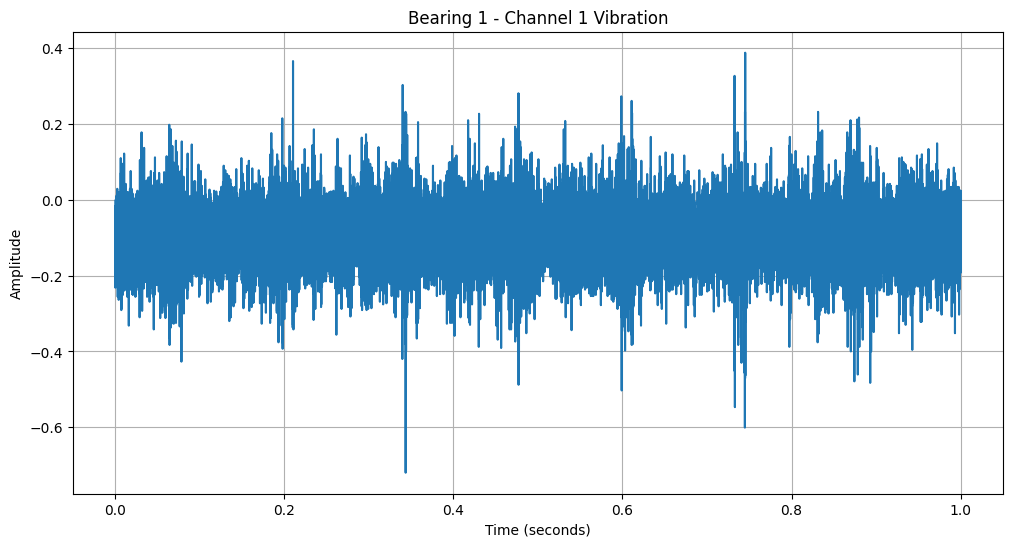

In [27]:
# Create time array for x-axis (remember, 20,480 points over 1 second)
time = np.linspace(0, 1, 20480)  # generates 20,480 evenly spaced points from 0 to 1 second
# Create the plot
plt.figure(figsize=(12, 6))  # Set figure size (width=12, height=6 inches)
plt.plot(time, raw_data_1[:, 0])  # Plot channel 1 ([:, 0] means all rows, first column)
plt.title('Bearing 1 - Channel 1 Vibration')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

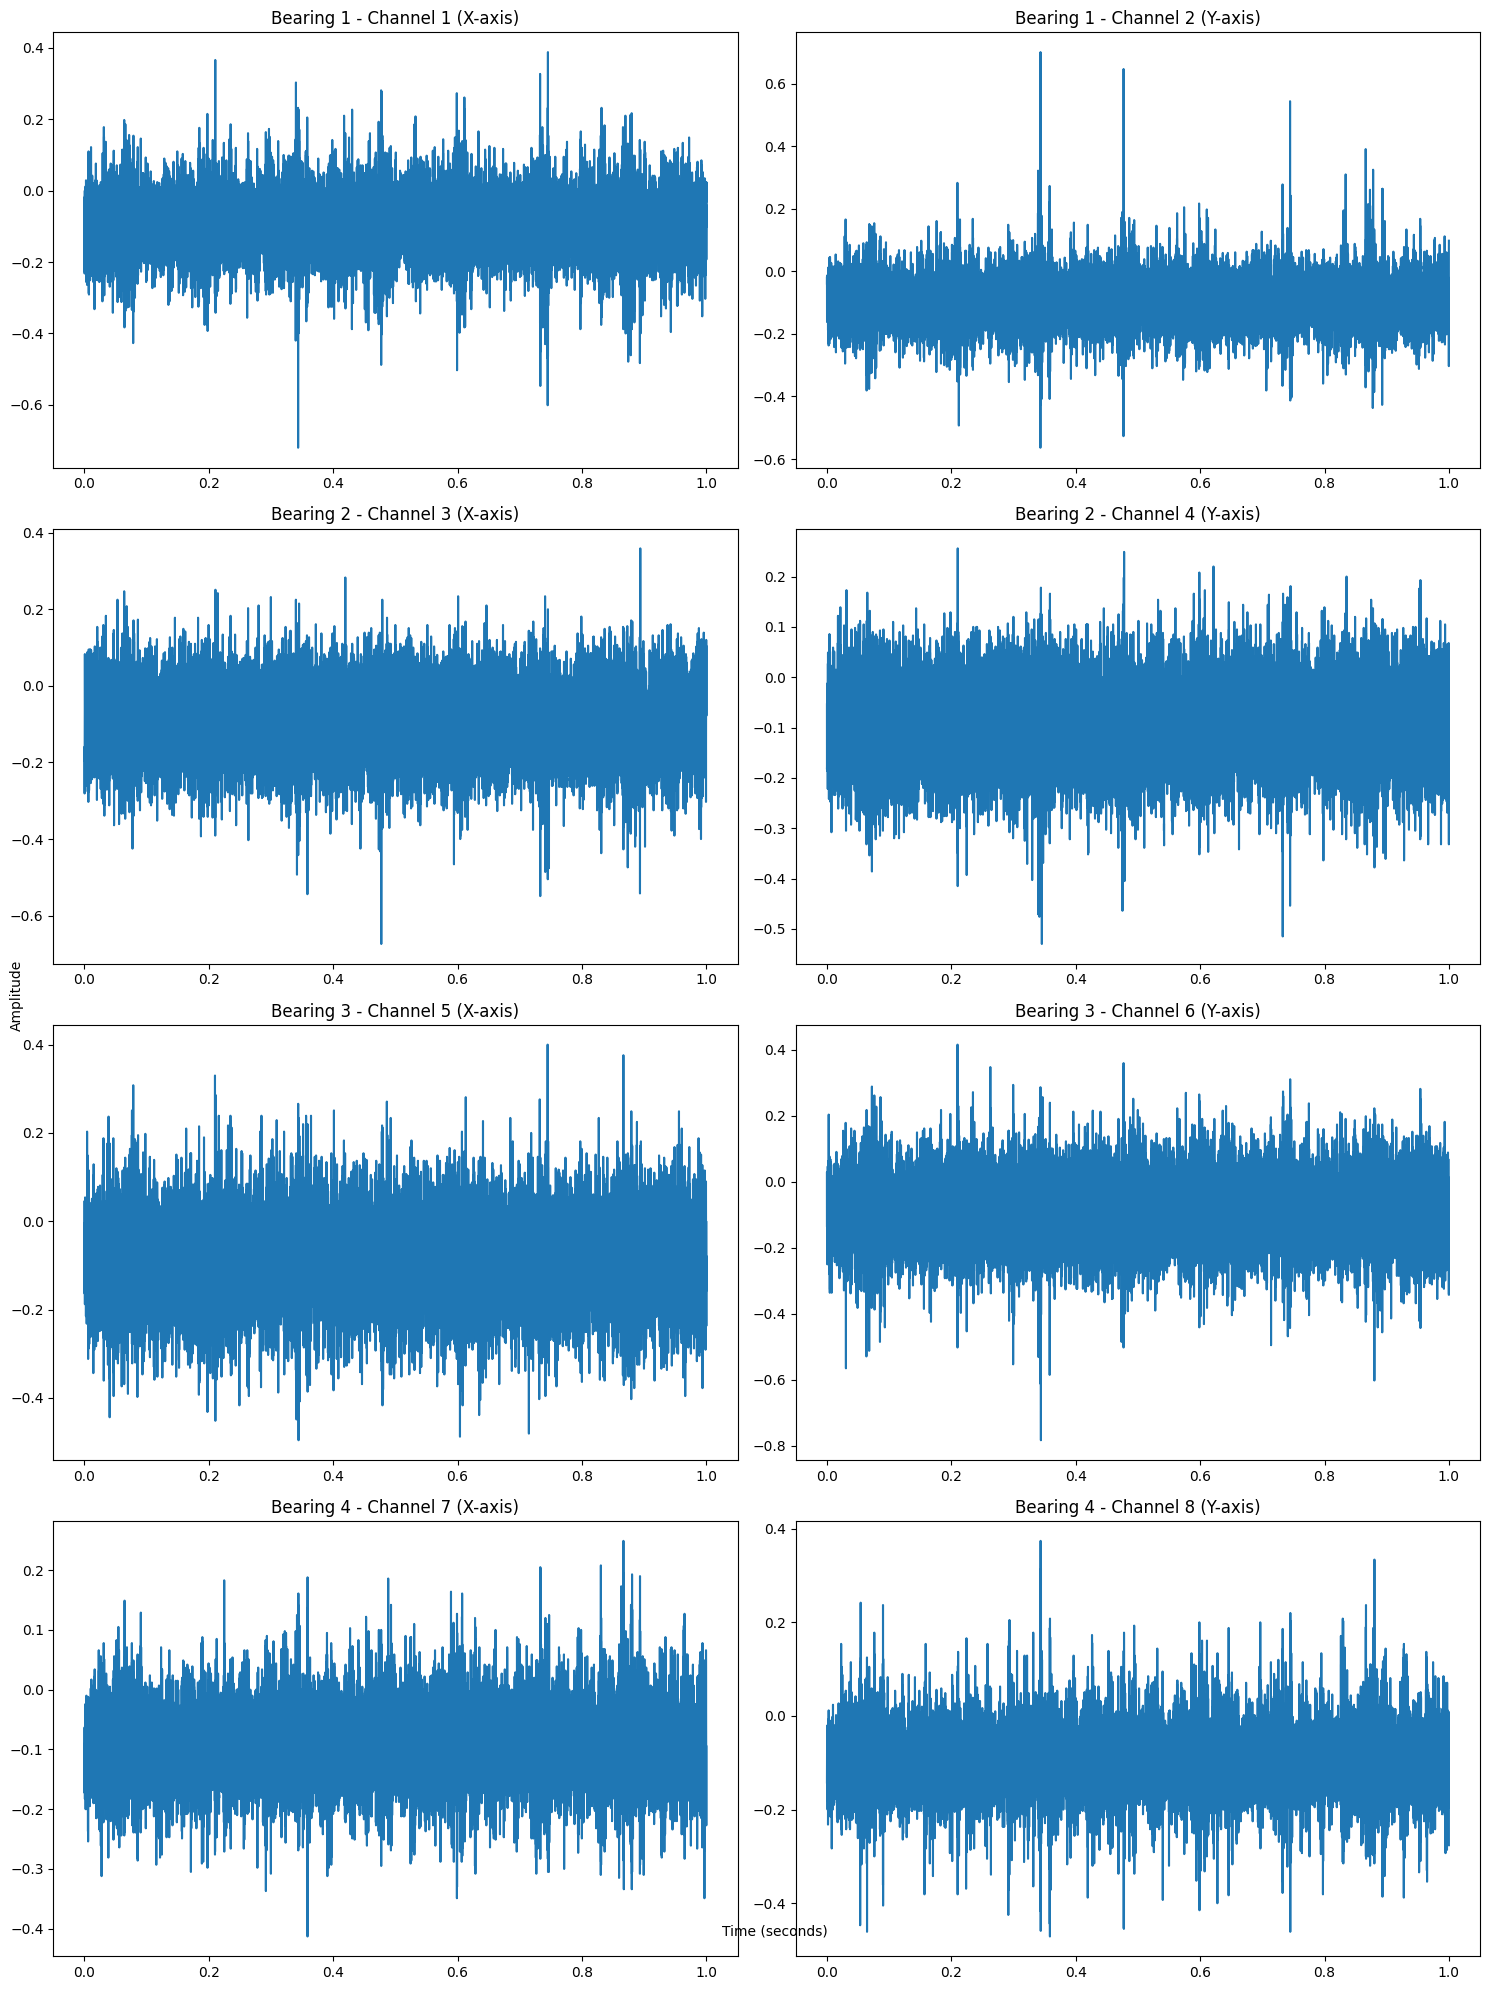

In [39]:
# Create figure with 4x2 subplots (4 bearings × 2 channels)
fig, axes = plt.subplots(4, 2, figsize=(15, 20))  # Taller figure to fit all plots

# Plot each bearing's channels
# Bearing 1
axes[0,0].plot(time, raw_data_1[:, 0])
axes[0,0].set_title('Bearing 1 - Channel 1 (X-axis)')
axes[0,1].plot(time, raw_data_1[:, 1])
axes[0,1].set_title('Bearing 1 - Channel 2 (Y-axis)')

# Bearing 2
axes[1,0].plot(time, raw_data_1[:, 2])
axes[1,0].set_title('Bearing 2 - Channel 3 (X-axis)')
axes[1,1].plot(time, raw_data_1[:, 3])
axes[1,1].set_title('Bearing 2 - Channel 4 (Y-axis)')

# Bearing 3
axes[2,0].plot(time, raw_data_1[:, 4])
axes[2,0].set_title('Bearing 3 - Channel 5 (X-axis)')
axes[2,1].plot(time, raw_data_1[:, 5])
axes[2,1].set_title('Bearing 3 - Channel 6 (Y-axis)')

# Bearing 4
axes[3,0].plot(time, raw_data_1[:, 6])
axes[3,0].set_title('Bearing 4 - Channel 7 (X-axis)')
axes[3,1].plot(time, raw_data_1[:, 7])
axes[3,1].set_title('Bearing 4 - Channel 8 (Y-axis)')

# Add common labels and adjust layout
fig.text(0.52, 0.03, 'Time (seconds)', ha='center')
fig.text(0.01, 0.5, 'Amplitude', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

In [86]:
def get_bearing_statistics(data):
    stats_dict = {}
    
    # Get number of channels from data shape
    num_channels = data.shape[1]  # This will be 8 for Set 1, 4 for Sets 2&3
    
    for channel in range(num_channels):
        channel_data = data[:, channel]
        
        stats_dict[f'Channel_{channel+1}'] = {
            'mean': np.mean(channel_data),
            'std': np.std(channel_data),
            'max': np.max(channel_data),
            'min': np.min(channel_data),
            'rms': np.sqrt(np.mean(channel_data**2)),
            'peak_to_peak': np.max(channel_data) - np.min(channel_data)
        }
    
    return stats_dict

In [87]:
def process_bearing_files(data_path):
    timestamps = []
    all_stats = []
    
    for file in sorted(data_path.glob("*")):
        timestamps.append(file.stem)
        data = np.loadtxt(file)
        stats = get_bearing_statistics(data)  # Uses single function for all sets
        all_stats.append(stats)
    
    print(f"Total files processed: {len(timestamps)}")
    return timestamps, all_stats

In [89]:
timestamps_1, statistics_1 = process_bearing_files(data_path_1)
timestamps_2, statistics_2 = process_bearing_files(data_path_2)
timestamps_3, statistics_3 = process_bearing_files(data_path_3)

Total files processed: 2156
Total files processed: 984
Total files processed: 6324


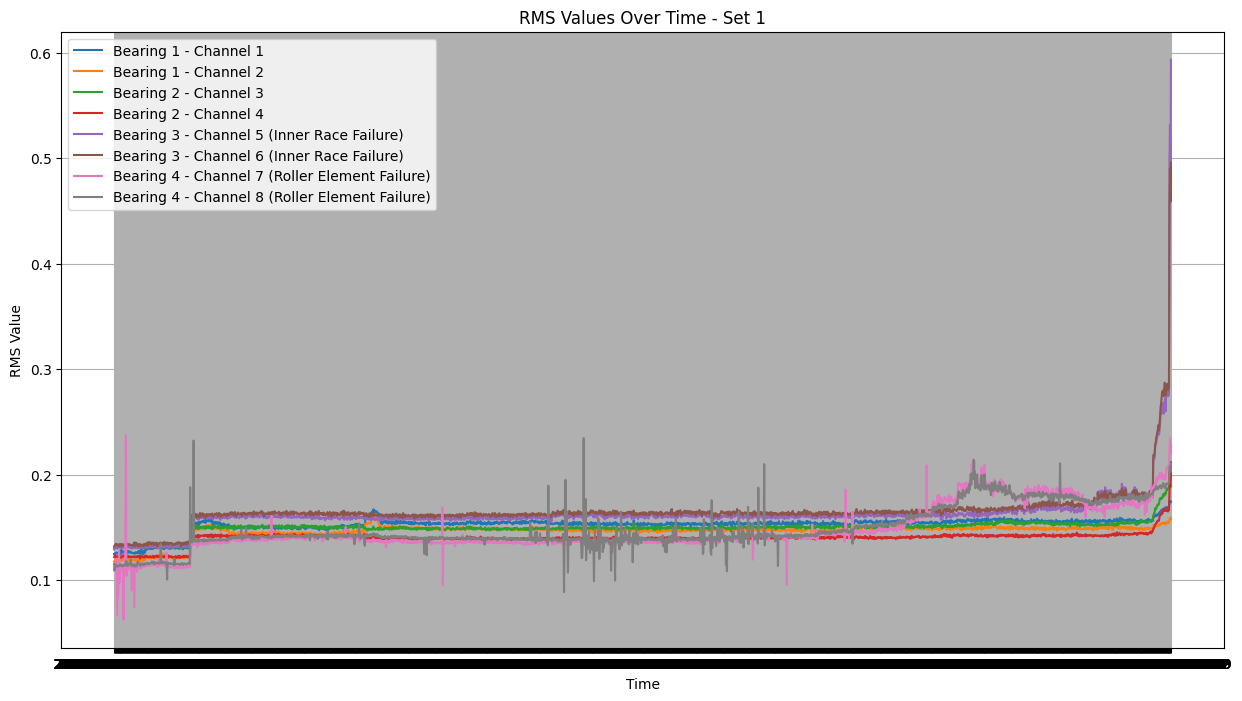

In [90]:
# Create lists to store data
times = []
bearing_stats = {
    'bearing1_ch1_rms': [], 'bearing1_ch2_rms': [],
    'bearing2_ch3_rms': [], 'bearing2_ch4_rms': [],
    'bearing3_ch5_rms': [], 'bearing3_ch6_rms': [],
    'bearing4_ch7_rms': [], 'bearing4_ch8_rms': []
}

# Extract RMS values for each channel over time
for time, stats in zip(timestamps_1, statistics_1):
    times.append(time)
    # Get RMS values for each channel of each bearing
    bearing_stats['bearing1_ch1_rms'].append(stats['Channel_1']['rms'])
    bearing_stats['bearing1_ch2_rms'].append(stats['Channel_2']['rms'])
    bearing_stats['bearing2_ch3_rms'].append(stats['Channel_3']['rms'])
    bearing_stats['bearing2_ch4_rms'].append(stats['Channel_4']['rms'])
    bearing_stats['bearing3_ch5_rms'].append(stats['Channel_5']['rms'])
    bearing_stats['bearing3_ch6_rms'].append(stats['Channel_6']['rms'])
    bearing_stats['bearing4_ch7_rms'].append(stats['Channel_7']['rms'])
    bearing_stats['bearing4_ch8_rms'].append(stats['Channel_8']['rms'])

# Create DataFrame
df_stats = pd.DataFrame(bearing_stats, index=times)

# Plot RMS trends for all channels
plt.figure(figsize=(15, 8))
plt.plot(df_stats['bearing1_ch1_rms'], label='Bearing 1 - Channel 1')
plt.plot(df_stats['bearing1_ch2_rms'], label='Bearing 1 - Channel 2')
plt.plot(df_stats['bearing2_ch3_rms'], label='Bearing 2 - Channel 3')
plt.plot(df_stats['bearing2_ch4_rms'], label='Bearing 2 - Channel 4')
plt.plot(df_stats['bearing3_ch5_rms'], label='Bearing 3 - Channel 5 (Inner Race Failure)')
plt.plot(df_stats['bearing3_ch6_rms'], label='Bearing 3 - Channel 6 (Inner Race Failure)')
plt.plot(df_stats['bearing4_ch7_rms'], label='Bearing 4 - Channel 7 (Roller Element Failure)')
plt.plot(df_stats['bearing4_ch8_rms'], label='Bearing 4 - Channel 8 (Roller Element Failure)')
plt.title('RMS Values Over Time - Set 1')
plt.xlabel('Time')
plt.ylabel('RMS Value')
plt.legend()
plt.grid(True)
plt.show()


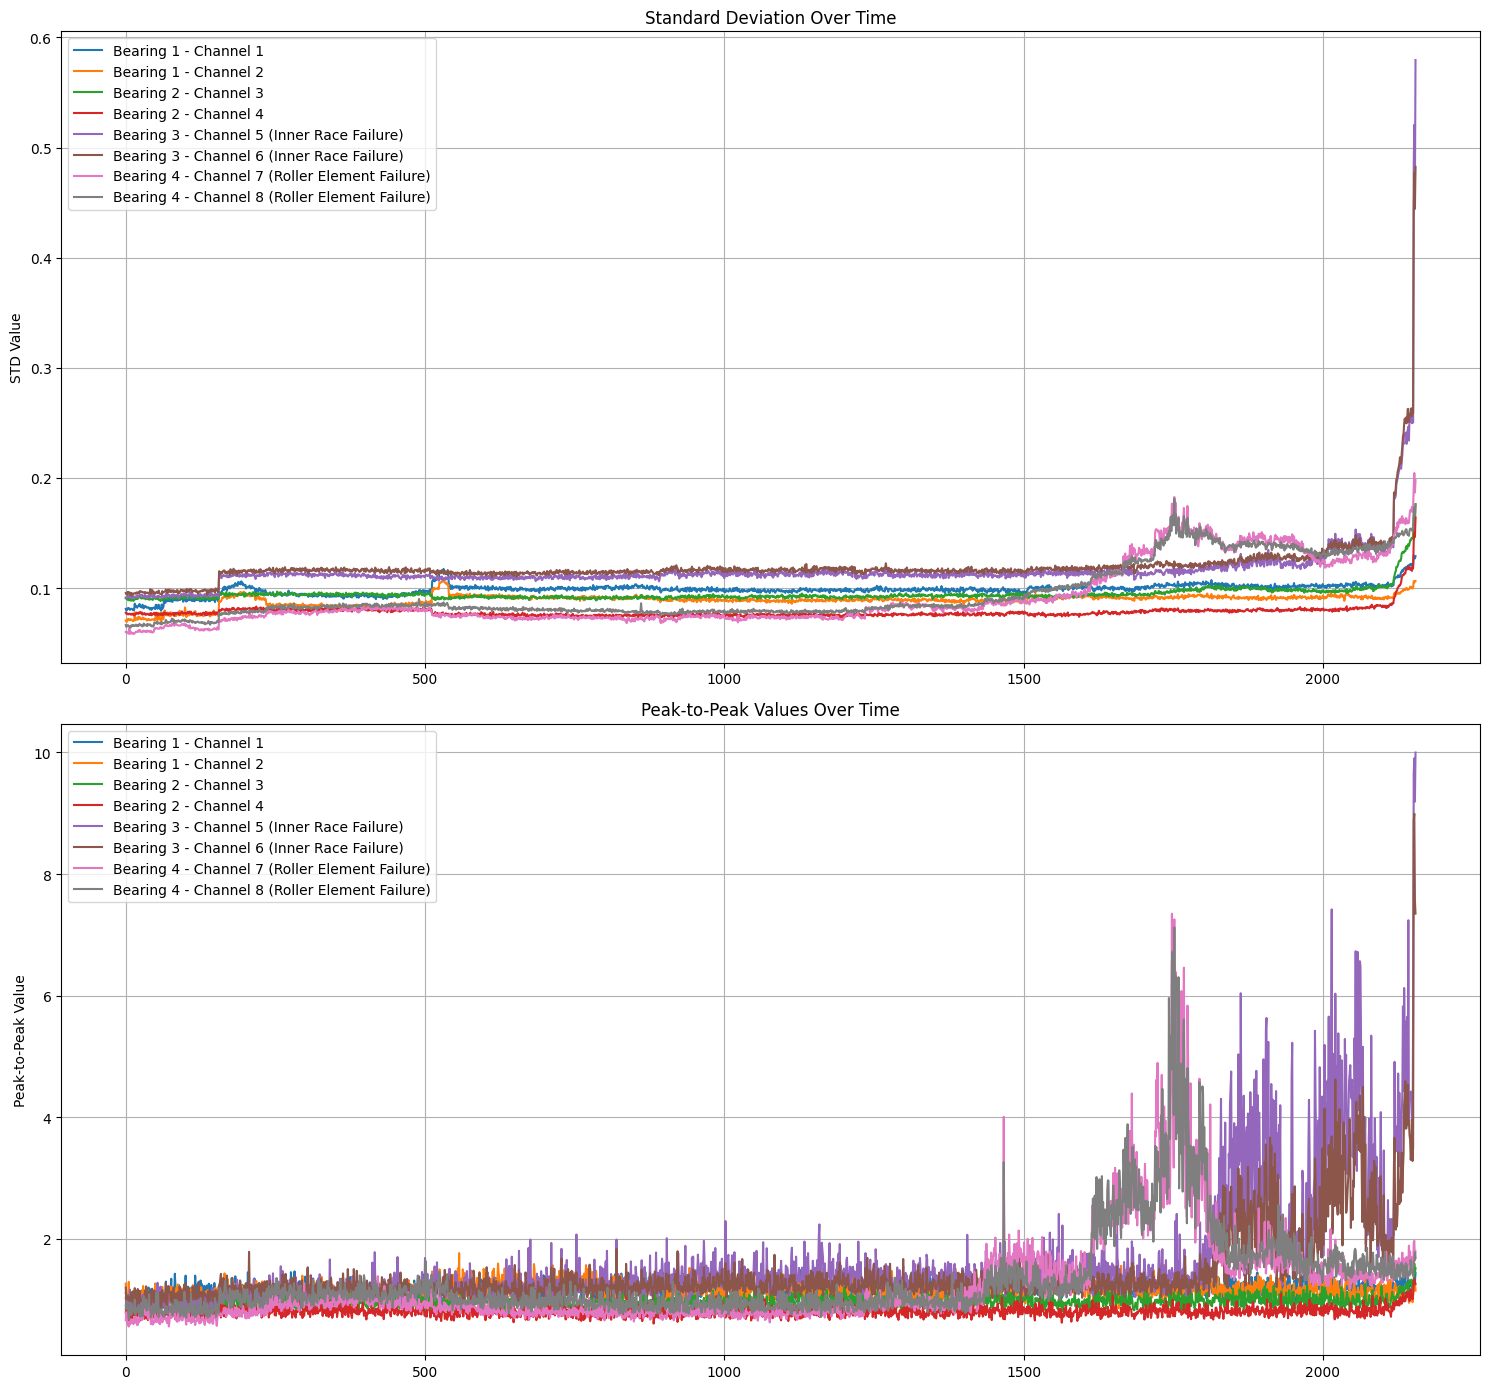

In [91]:
# Create figure with 2 subplots (std and peak-to-peak)
fig, axes = plt.subplots(2, 1, figsize=(15, 14))

# --- Standard Deviation ---
# Extracting std values for all 8 channels
bearing_std = {
    'bearing1_ch1_std': [stats['Channel_1']['std'] for stats in statistics_1],
    'bearing1_ch2_std': [stats['Channel_2']['std'] for stats in statistics_1],
    'bearing2_ch3_std': [stats['Channel_3']['std'] for stats in statistics_1],
    'bearing2_ch4_std': [stats['Channel_4']['std'] for stats in statistics_1],
    'bearing3_ch5_std': [stats['Channel_5']['std'] for stats in statistics_1],
    'bearing3_ch6_std': [stats['Channel_6']['std'] for stats in statistics_1],
    'bearing4_ch7_std': [stats['Channel_7']['std'] for stats in statistics_1],
    'bearing4_ch8_std': [stats['Channel_8']['std'] for stats in statistics_1]
}

# Plotting std values
axes[0].plot(bearing_std['bearing1_ch1_std'], label='Bearing 1 - Channel 1')
axes[0].plot(bearing_std['bearing1_ch2_std'], label='Bearing 1 - Channel 2')
axes[0].plot(bearing_std['bearing2_ch3_std'], label='Bearing 2 - Channel 3')
axes[0].plot(bearing_std['bearing2_ch4_std'], label='Bearing 2 - Channel 4')
axes[0].plot(bearing_std['bearing3_ch5_std'], label='Bearing 3 - Channel 5 (Inner Race Failure)')
axes[0].plot(bearing_std['bearing3_ch6_std'], label='Bearing 3 - Channel 6 (Inner Race Failure)')
axes[0].plot(bearing_std['bearing4_ch7_std'], label='Bearing 4 - Channel 7 (Roller Element Failure)')
axes[0].plot(bearing_std['bearing4_ch8_std'], label='Bearing 4 - Channel 8 (Roller Element Failure)')
axes[0].set_title('Standard Deviation Over Time')
axes[0].set_ylabel('STD Value')
axes[0].grid(True)
axes[0].legend()

# --- Peak-to-Peak ---
# Extracting peak-to-peak values for all 8 channels
bearing_p2p = {
    'bearing1_ch1_p2p': [stats['Channel_1']['peak_to_peak'] for stats in statistics_1],
    'bearing1_ch2_p2p': [stats['Channel_2']['peak_to_peak'] for stats in statistics_1],
    'bearing2_ch3_p2p': [stats['Channel_3']['peak_to_peak'] for stats in statistics_1],
    'bearing2_ch4_p2p': [stats['Channel_4']['peak_to_peak'] for stats in statistics_1],
    'bearing3_ch5_p2p': [stats['Channel_5']['peak_to_peak'] for stats in statistics_1],
    'bearing3_ch6_p2p': [stats['Channel_6']['peak_to_peak'] for stats in statistics_1],
    'bearing4_ch7_p2p': [stats['Channel_7']['peak_to_peak'] for stats in statistics_1],
    'bearing4_ch8_p2p': [stats['Channel_8']['peak_to_peak'] for stats in statistics_1]
}

# Plotting peak-to-peak values
axes[1].plot(bearing_p2p['bearing1_ch1_p2p'], label='Bearing 1 - Channel 1')
axes[1].plot(bearing_p2p['bearing1_ch2_p2p'], label='Bearing 1 - Channel 2')
axes[1].plot(bearing_p2p['bearing2_ch3_p2p'], label='Bearing 2 - Channel 3')
axes[1].plot(bearing_p2p['bearing2_ch4_p2p'], label='Bearing 2 - Channel 4')
axes[1].plot(bearing_p2p['bearing3_ch5_p2p'], label='Bearing 3 - Channel 5 (Inner Race Failure)')
axes[1].plot(bearing_p2p['bearing3_ch6_p2p'], label='Bearing 3 - Channel 6 (Inner Race Failure)')
axes[1].plot(bearing_p2p['bearing4_ch7_p2p'], label='Bearing 4 - Channel 7 (Roller Element Failure)')
axes[1].plot(bearing_p2p['bearing4_ch8_p2p'], label='Bearing 4 - Channel 8 (Roller Element Failure)')
axes[1].set_title('Peak-to-Peak Values Over Time')
axes[1].set_ylabel('Peak-to-Peak Value')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


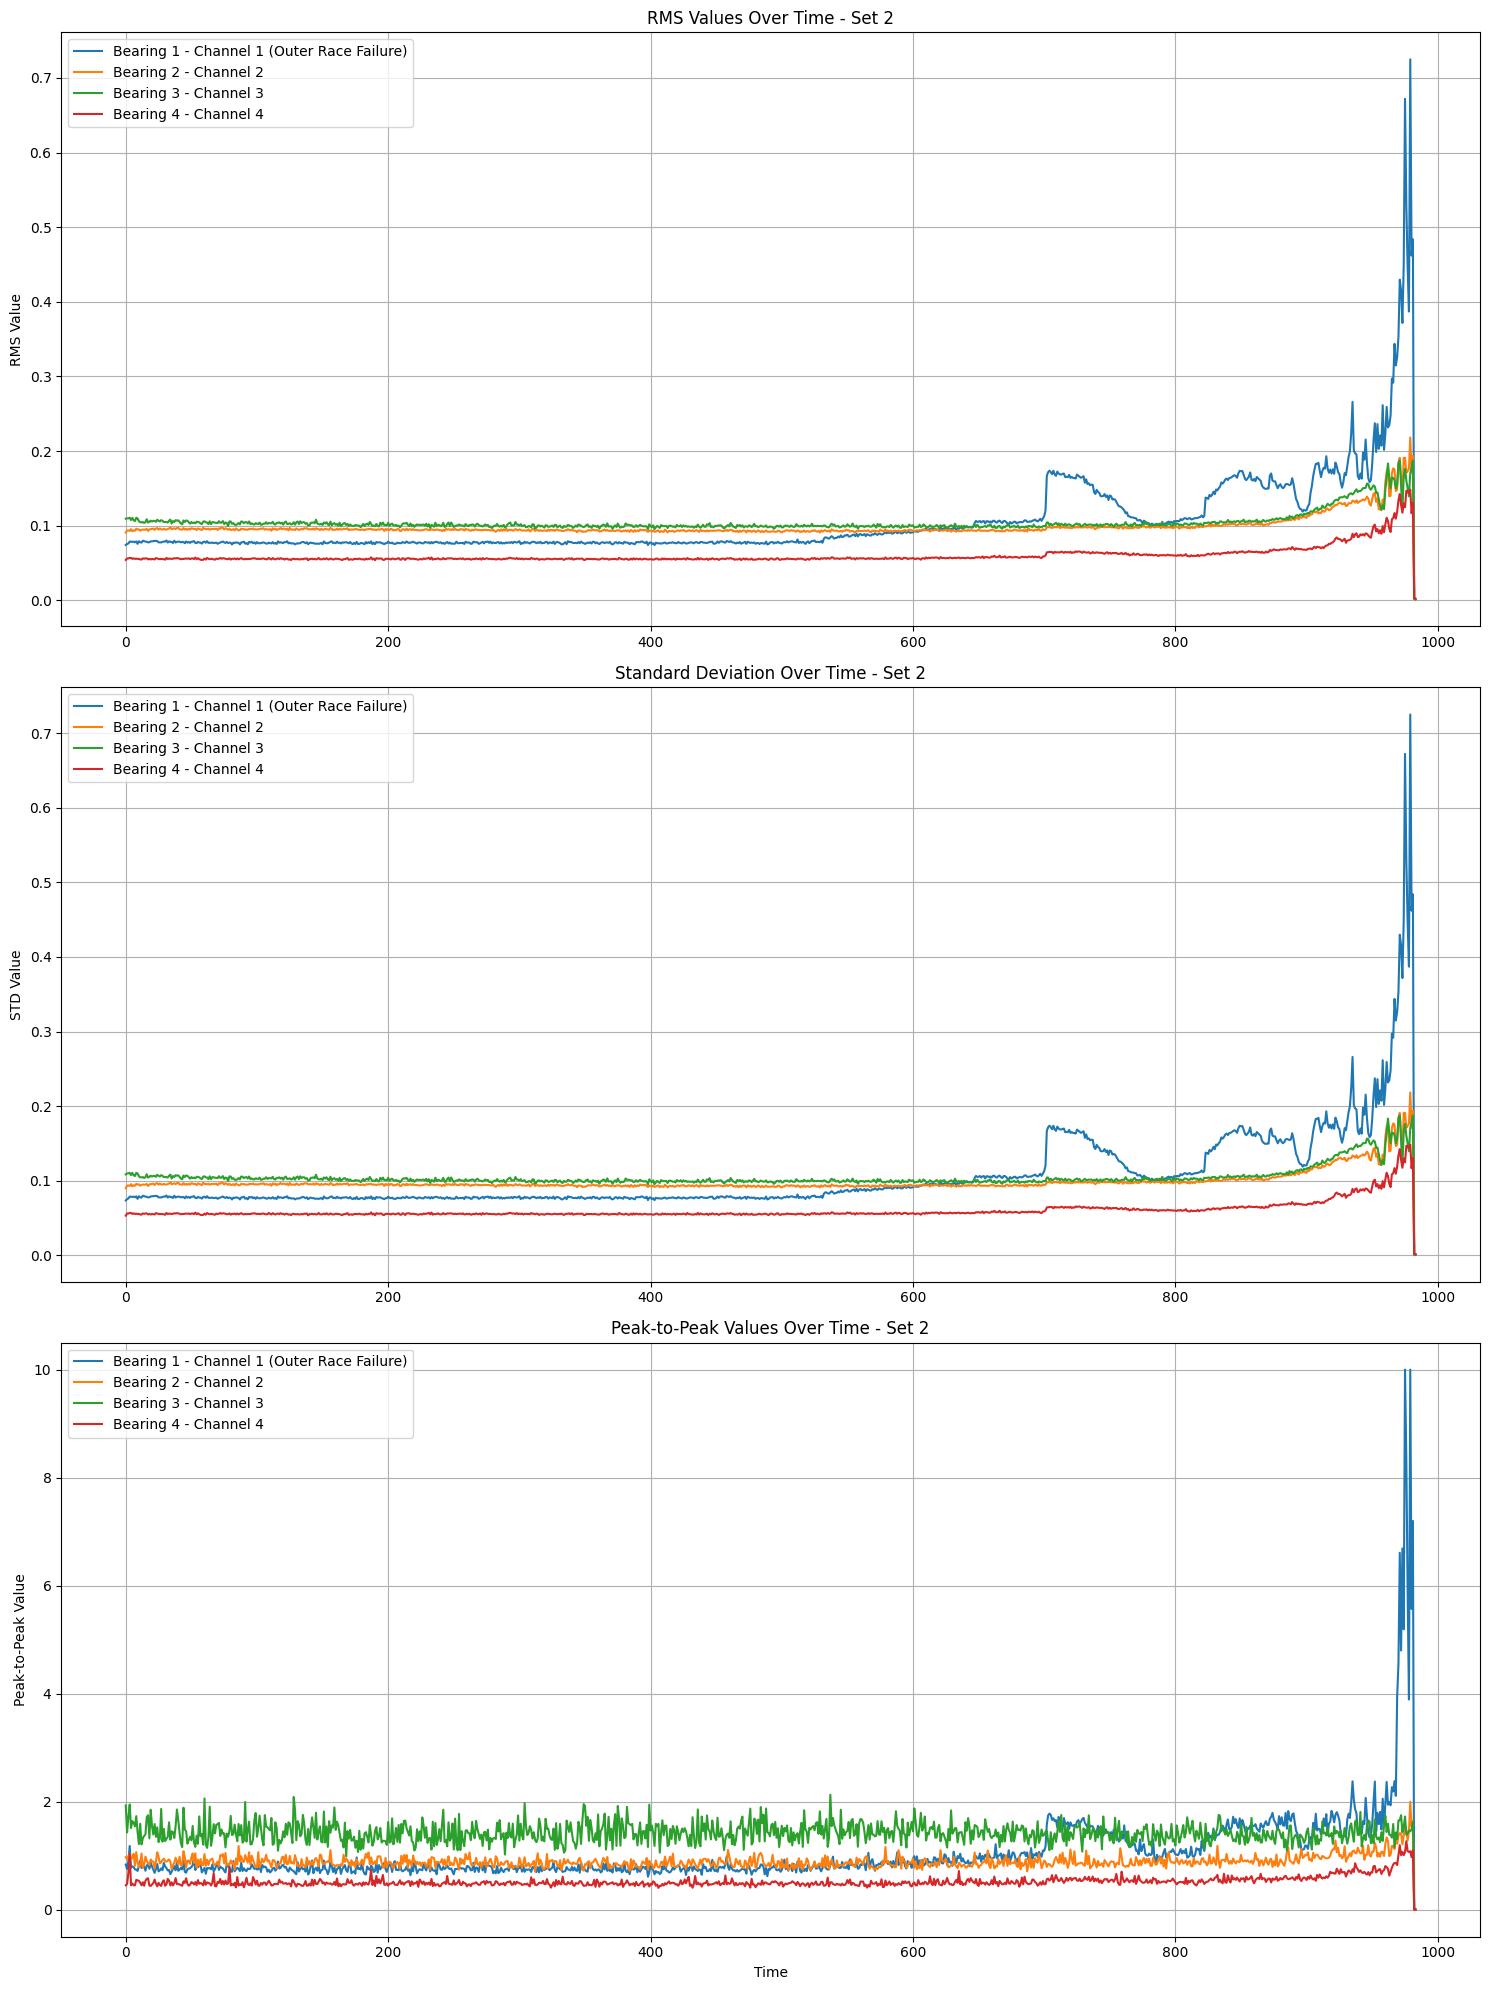

In [ ]:
# Create figure with 3 subplots (RMS, STD, and peak-to-peak)
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

# --- RMS Values ---
bearing_stats_2 = {
    'bearing1_ch1_rms': [],  # Bearing 1 - outer race failure
    'bearing2_ch2_rms': [],
    'bearing3_ch3_rms': [],
    'bearing4_ch4_rms': []
}

for stats in statistics_2:
    bearing_stats_2['bearing1_ch1_rms'].append(stats['Channel_1']['rms'])
    bearing_stats_2['bearing2_ch2_rms'].append(stats['Channel_2']['rms'])
    bearing_stats_2['bearing3_ch3_rms'].append(stats['Channel_3']['rms'])
    bearing_stats_2['bearing4_ch4_rms'].append(stats['Channel_4']['rms'])

# Plot RMS values
axes[0].plot(bearing_stats_2['bearing1_ch1_rms'], label='Bearing 1 - Channel 1 (Outer Race Failure)')
axes[0].plot(bearing_stats_2['bearing2_ch2_rms'], label='Bearing 2 - Channel 2')
axes[0].plot(bearing_stats_2['bearing3_ch3_rms'], label='Bearing 3 - Channel 3')
axes[0].plot(bearing_stats_2['bearing4_ch4_rms'], label='Bearing 4 - Channel 4')
axes[0].set_title('RMS Values Over Time - Set 2')
axes[0].set_ylabel('RMS Value')
axes[0].grid(True)
axes[0].legend()

# --- Standard Deviation ---
bearing_std_2 = {
    'bearing1_ch1_std': [stats['Channel_1']['std'] for stats in statistics_2],
    'bearing2_ch2_std': [stats['Channel_2']['std'] for stats in statistics_2],
    'bearing3_ch3_std': [stats['Channel_3']['std'] for stats in statistics_2],
    'bearing4_ch4_std': [stats['Channel_4']['std'] for stats in statistics_2]
}

# Plot STD values
axes[1].plot(bearing_std_2['bearing1_ch1_std'], label='Bearing 1 - Channel 1 (Outer Race Failure)')
axes[1].plot(bearing_std_2['bearing2_ch2_std'], label='Bearing 2 - Channel 2')
axes[1].plot(bearing_std_2['bearing3_ch3_std'], label='Bearing 3 - Channel 3')
axes[1].plot(bearing_std_2['bearing4_ch4_std'], label='Bearing 4 - Channel 4')
axes[1].set_title('Standard Deviation Over Time - Set 2')
axes[1].set_ylabel('STD Value')
axes[1].grid(True)
axes[1].legend()

# --- Peak-to-Peak ---
bearing_p2p_2 = {
    'bearing1_ch1_p2p': [stats['Channel_1']['peak_to_peak'] for stats in statistics_2],
    'bearing2_ch2_p2p': [stats['Channel_2']['peak_to_peak'] for stats in statistics_2],
    'bearing3_ch3_p2p': [stats['Channel_3']['peak_to_peak'] for stats in statistics_2],
    'bearing4_ch4_p2p': [stats['Channel_4']['peak_to_peak'] for stats in statistics_2]
}

# Plot Peak-to-Peak values
axes[2].plot(bearing_p2p_2['bearing1_ch1_p2p'], label='Bearing 1 - Channel 1 (Outer Race Failure)')
axes[2].plot(bearing_p2p_2['bearing2_ch2_p2p'], label='Bearing 2 - Channel 2')
axes[2].plot(bearing_p2p_2['bearing3_ch3_p2p'], label='Bearing 3 - Channel 3')
axes[2].plot(bearing_p2p_2['bearing4_ch4_p2p'], label='Bearing 4 - Channel 4')
axes[2].set_title('Peak-to-Peak Values Over Time - Set 2')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Peak-to-Peak Value')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

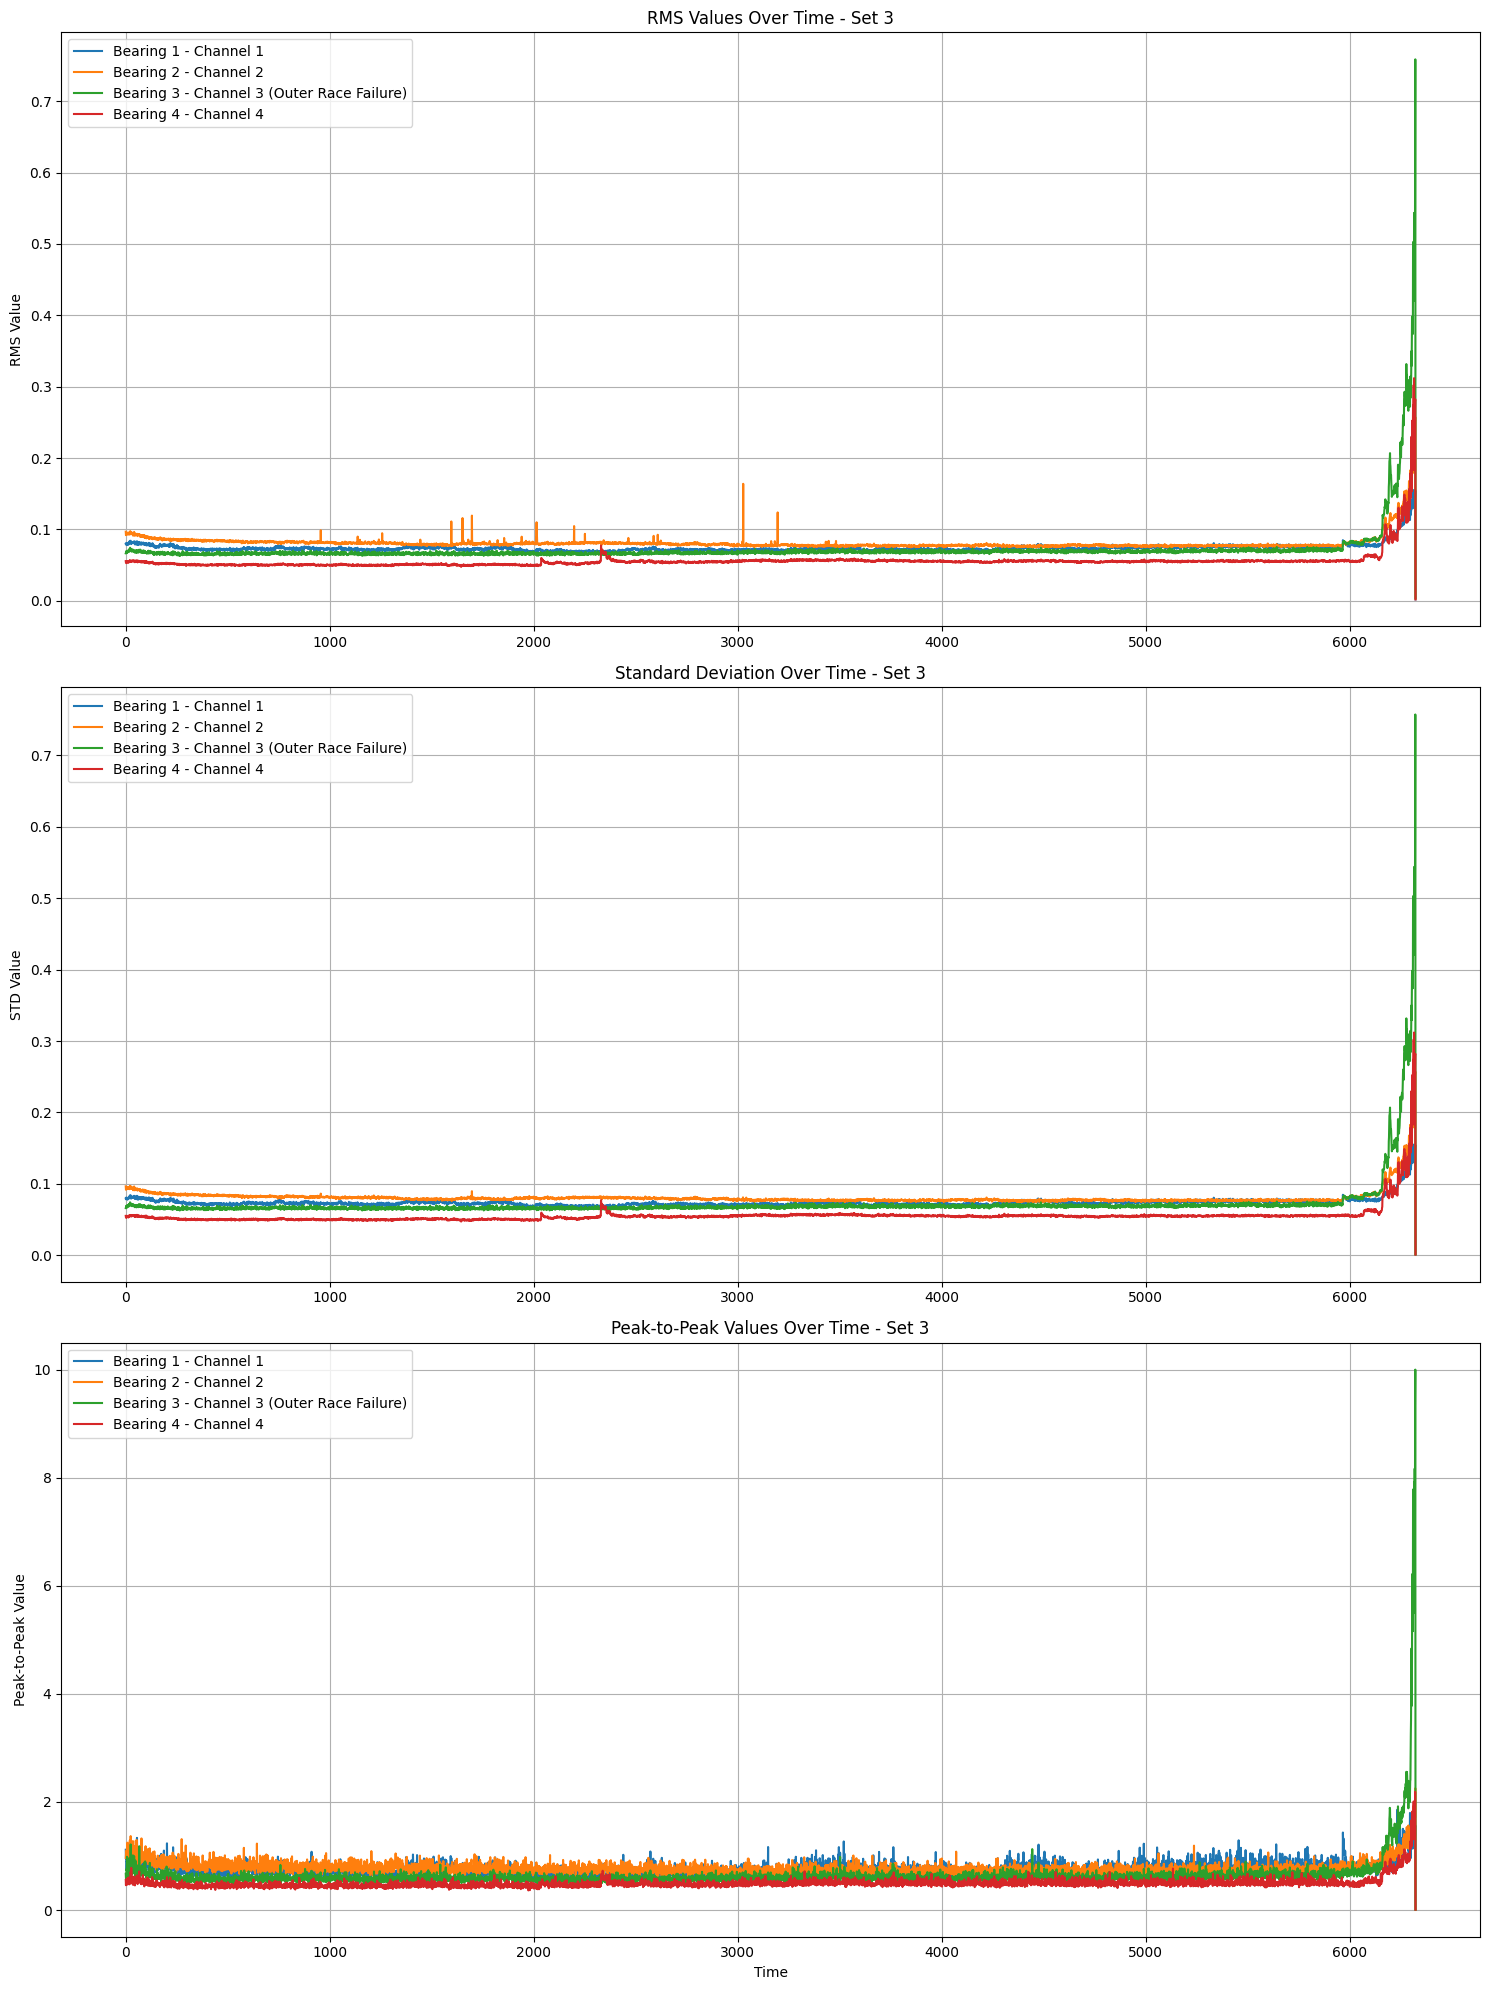

In [94]:
# Create figure with 3 subplots (RMS, STD, and peak-to-peak)
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

# --- RMS Values ---
bearing_stats_3 = {
    'bearing1_ch1_rms': [],
    'bearing2_ch2_rms': [],
    'bearing3_ch3_rms': [],  # Bearing 3 - outer race failure
    'bearing4_ch4_rms': []
}

for stats in statistics_3:
    bearing_stats_3['bearing1_ch1_rms'].append(stats['Channel_1']['rms'])
    bearing_stats_3['bearing2_ch2_rms'].append(stats['Channel_2']['rms'])
    bearing_stats_3['bearing3_ch3_rms'].append(stats['Channel_3']['rms'])
    bearing_stats_3['bearing4_ch4_rms'].append(stats['Channel_4']['rms'])

# Plot RMS values
axes[0].plot(bearing_stats_3['bearing1_ch1_rms'], label='Bearing 1 - Channel 1')
axes[0].plot(bearing_stats_3['bearing2_ch2_rms'], label='Bearing 2 - Channel 2')
axes[0].plot(bearing_stats_3['bearing3_ch3_rms'], label='Bearing 3 - Channel 3 (Outer Race Failure)')
axes[0].plot(bearing_stats_3['bearing4_ch4_rms'], label='Bearing 4 - Channel 4')
axes[0].set_title('RMS Values Over Time - Set 3')
axes[0].set_ylabel('RMS Value')
axes[0].grid(True)
axes[0].legend()

# --- Standard Deviation ---
bearing_std_3 = {
    'bearing1_ch1_std': [stats['Channel_1']['std'] for stats in statistics_3],
    'bearing2_ch2_std': [stats['Channel_2']['std'] for stats in statistics_3],
    'bearing3_ch3_std': [stats['Channel_3']['std'] for stats in statistics_3],
    'bearing4_ch4_std': [stats['Channel_4']['std'] for stats in statistics_3]
}

# Plot STD values
axes[1].plot(bearing_std_3['bearing1_ch1_std'], label='Bearing 1 - Channel 1')
axes[1].plot(bearing_std_3['bearing2_ch2_std'], label='Bearing 2 - Channel 2')
axes[1].plot(bearing_std_3['bearing3_ch3_std'], label='Bearing 3 - Channel 3 (Outer Race Failure)')
axes[1].plot(bearing_std_3['bearing4_ch4_std'], label='Bearing 4 - Channel 4')
axes[1].set_title('Standard Deviation Over Time - Set 3')
axes[1].set_ylabel('STD Value')
axes[1].grid(True)
axes[1].legend()

# --- Peak-to-Peak ---
bearing_p2p_3 = {
    'bearing1_ch1_p2p': [stats['Channel_1']['peak_to_peak'] for stats in statistics_3],
    'bearing2_ch2_p2p': [stats['Channel_2']['peak_to_peak'] for stats in statistics_3],
    'bearing3_ch3_p2p': [stats['Channel_3']['peak_to_peak'] for stats in statistics_3],
    'bearing4_ch4_p2p': [stats['Channel_4']['peak_to_peak'] for stats in statistics_3]
}

# Plot Peak-to-Peak values
axes[2].plot(bearing_p2p_3['bearing1_ch1_p2p'], label='Bearing 1 - Channel 1')
axes[2].plot(bearing_p2p_3['bearing2_ch2_p2p'], label='Bearing 2 - Channel 2')
axes[2].plot(bearing_p2p_3['bearing3_ch3_p2p'], label='Bearing 3 - Channel 3 (Outer Race Failure)')
axes[2].plot(bearing_p2p_3['bearing4_ch4_p2p'], label='Bearing 4 - Channel 4')
axes[2].set_title('Peak-to-Peak Values Over Time - Set 3')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Peak-to-Peak Value')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

In [98]:
from datetime import datetime
def parse_timestamp(ts):
    """Parse timestamp from format '2003.10.22.12.06' to datetime"""
    parts = ts.split('.')
    year, month, day, hour, minute = map(int, parts)
    return datetime(year, month, day, hour, minute)

# Test it with one timestamp to make sure it works
test_date = parse_timestamp(timestamps_1[0])
print("Original timestamp:", timestamps_1[0])
print("Parsed datetime:", test_date)

Original timestamp: 2003.10.22.12.06
Parsed datetime: 2003-10-22 12:06:00


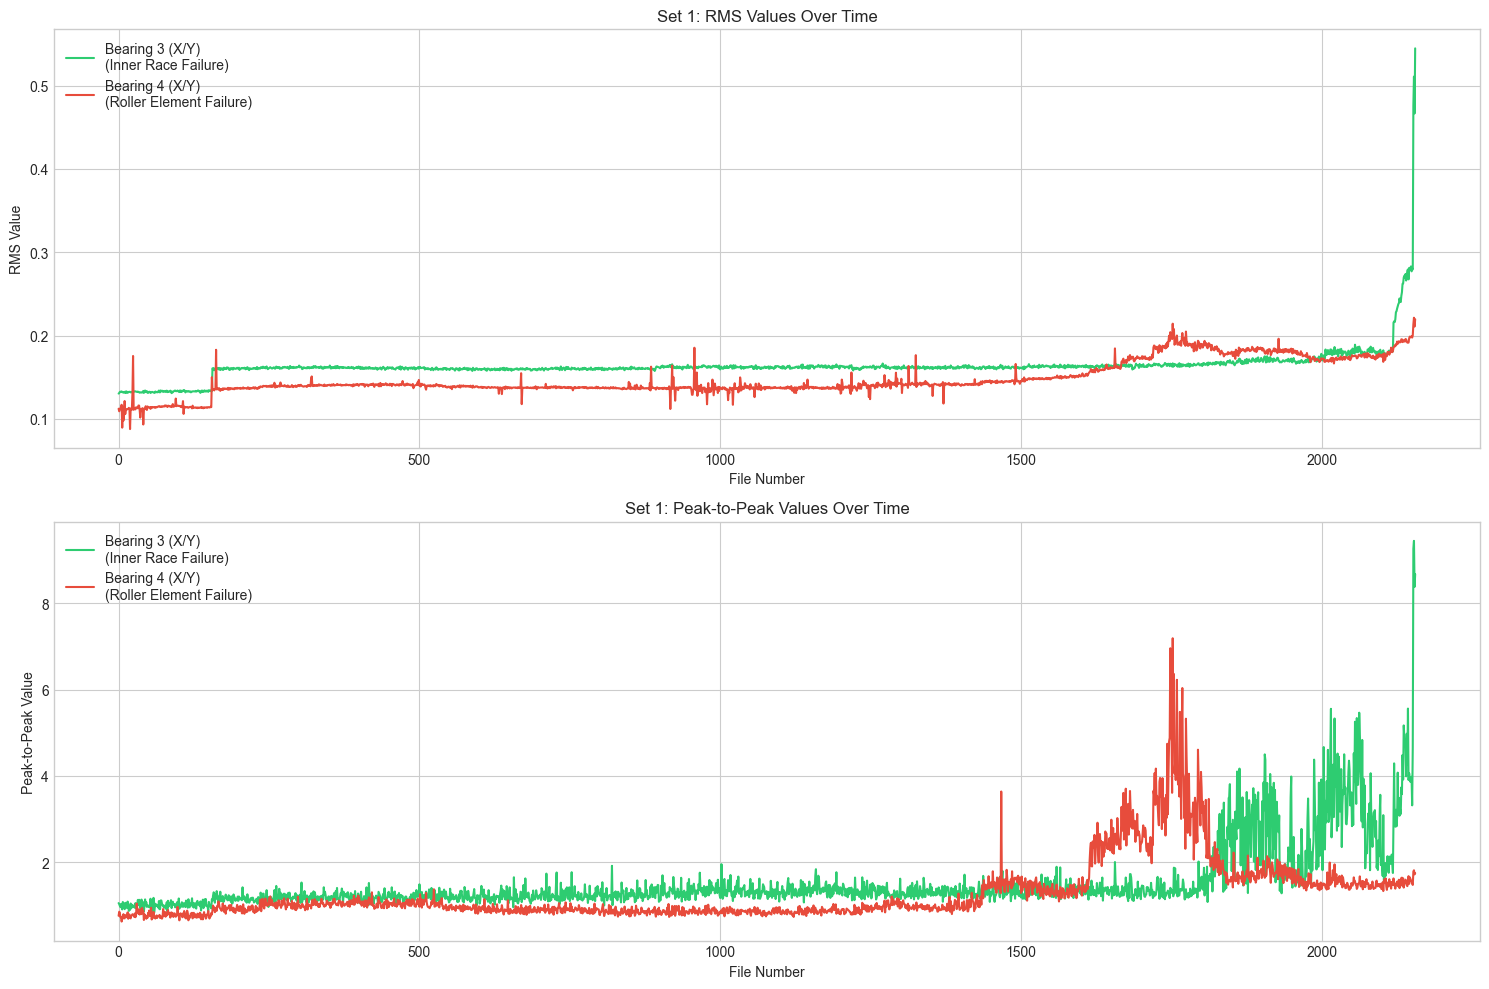

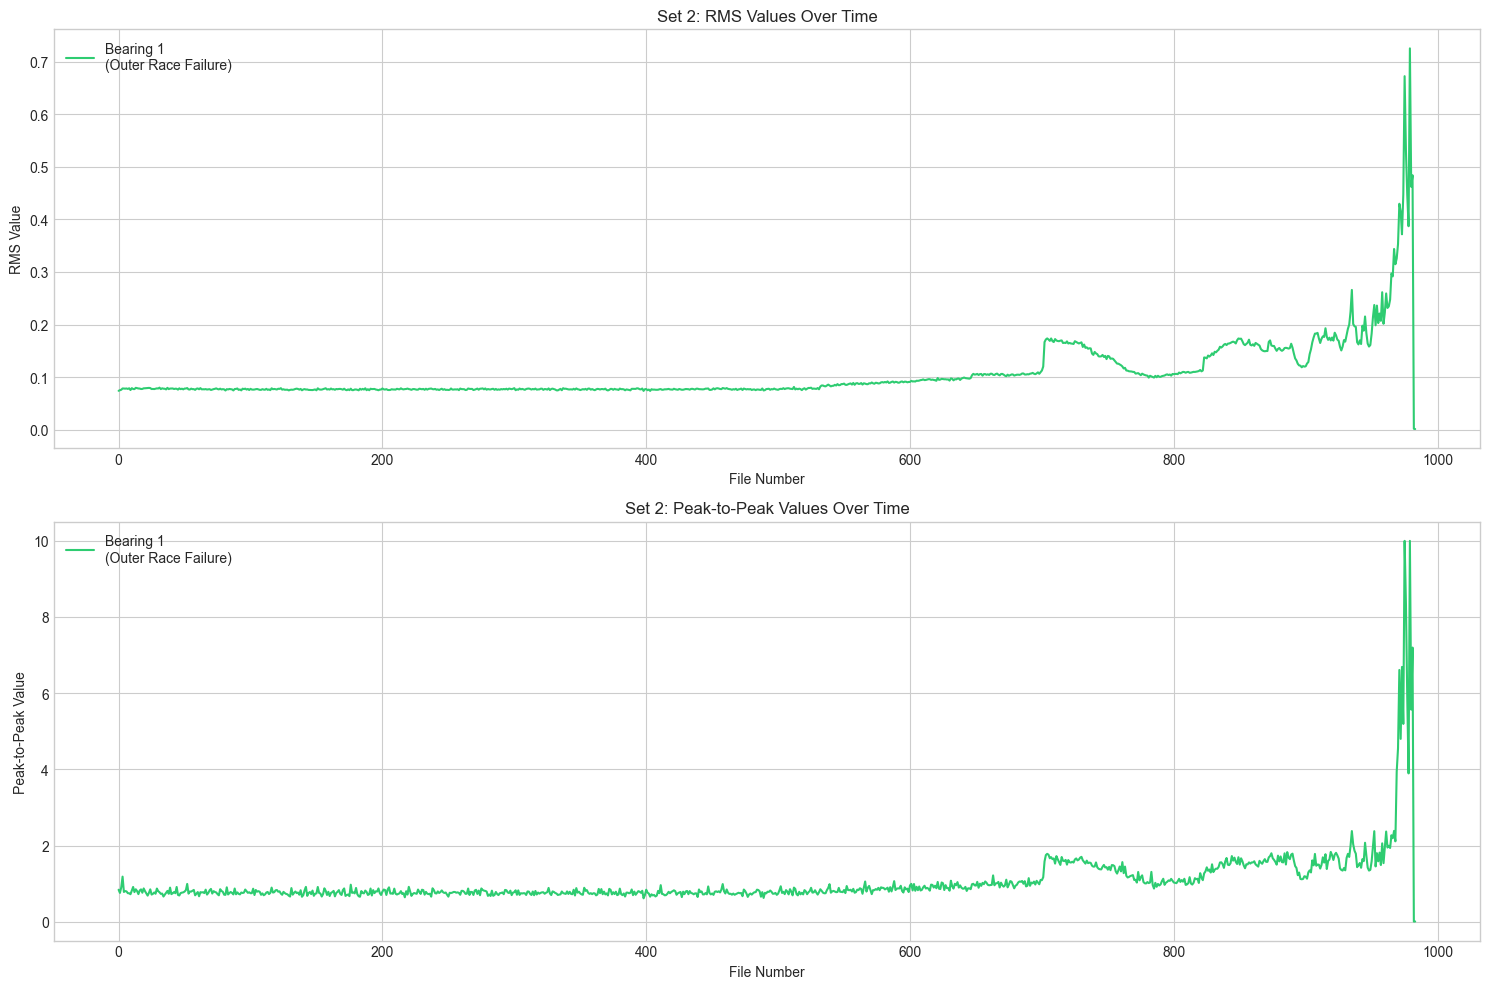

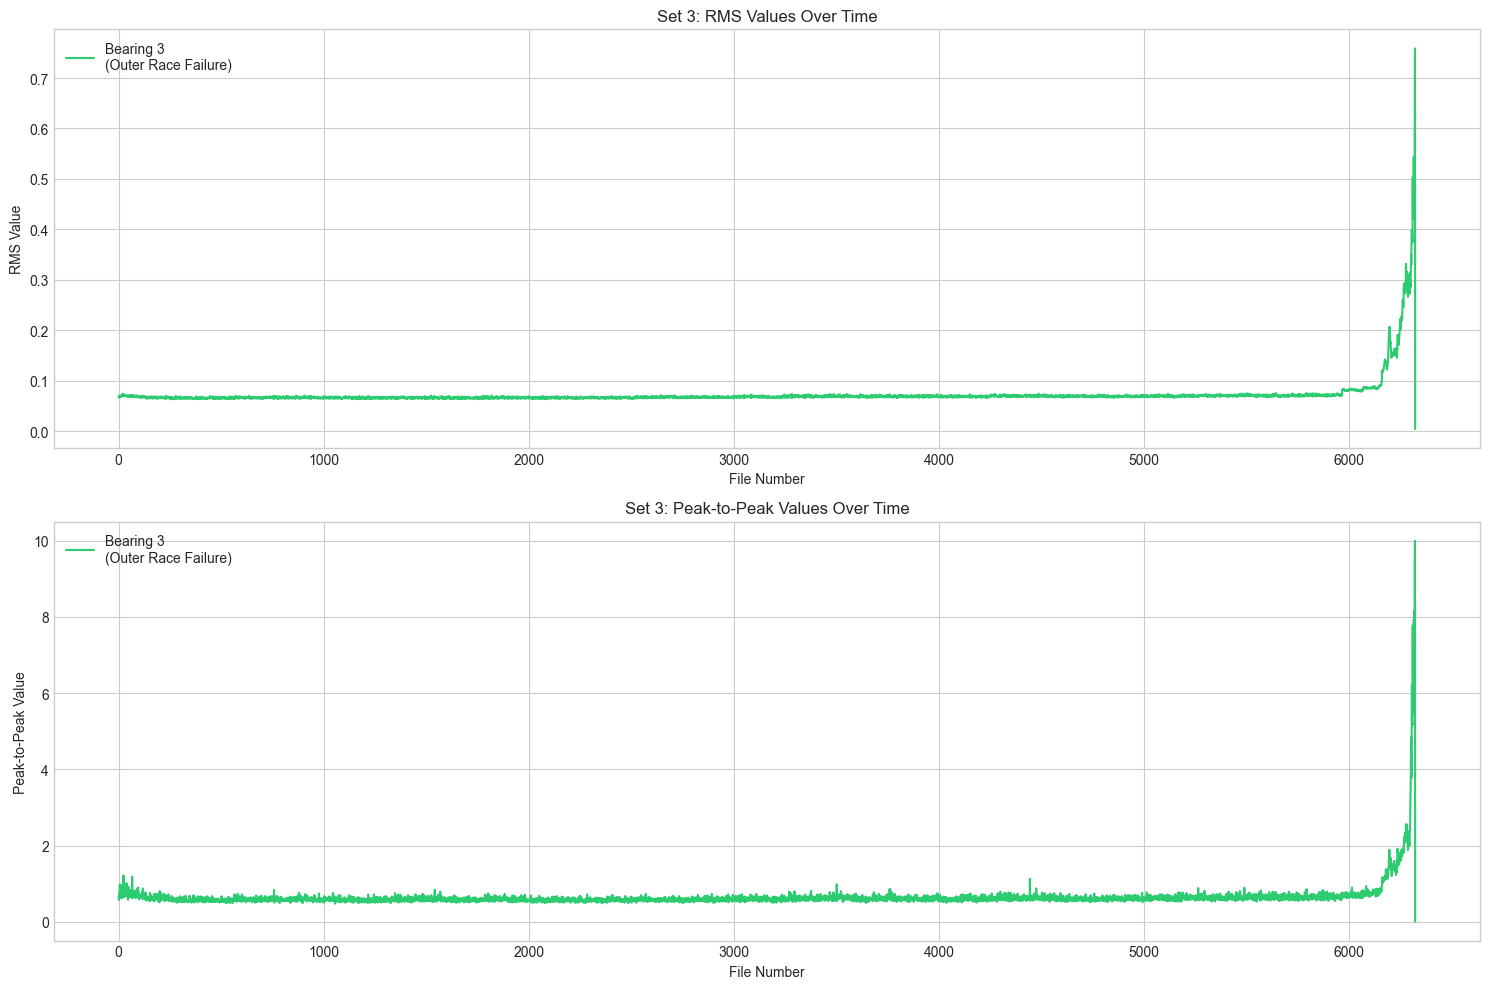

In [109]:
def plot_failing_bearings(statistics, set_num, failed_bearings):
    """
    Plot RMS and Peak-to-Peak values for failing bearings using indices instead of timestamps.
    
    Parameters:
        statistics: List of dictionaries containing bearing statistics
        set_num: Dataset number (1, 2, or 3)
        failed_bearings: Dict mapping bearing numbers to failure types
    """
    # Create indices for x-axis (file numbers)
    indices = np.arange(len(statistics))
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Color map for different bearings
    colors = ['#2ecc71', '#e74c3c']
    
    # Plot each failing bearing
    for idx, (bearing_num, failure_type) in enumerate(failed_bearings.items()):
        # Get the right channels based on dataset
        if set_num == 1:
            # Set 1 has 2 channels per bearing
            channels = [f'Channel_{2*bearing_num-1}', f'Channel_{2*bearing_num}']
            label_suffix = ' (X/Y)'
        else:
            # Sets 2 and 3 have 1 channel per bearing
            channels = [f'Channel_{bearing_num}']
            label_suffix = ''
        
        # Extract values
        rms_values = []
        p2p_values = []
        
        for stats in statistics:
            # Average across channels for this bearing
            bearing_rms = np.mean([stats[ch]['rms'] for ch in channels])
            bearing_p2p = np.mean([stats[ch]['peak_to_peak'] for ch in channels])
            rms_values.append(bearing_rms)
            p2p_values.append(bearing_p2p)
        
        # Plot
        ax1.plot(indices, rms_values, 
                label=f'Bearing {bearing_num}{label_suffix}\n({failure_type})',
                color=colors[idx])
        
        ax2.plot(indices, p2p_values,
                label=f'Bearing {bearing_num}{label_suffix}\n({failure_type})',
                color=colors[idx])
    
    # Customize plots
    ax1.set_title(f'Set {set_num}: RMS Values Over Time')
    ax1.set_ylabel('RMS Value')
    ax1.set_xlabel('File Number')
    ax1.grid(True)
    ax1.legend()
    
    ax2.set_title(f'Set {set_num}: Peak-to-Peak Values Over Time')
    ax2.set_ylabel('Peak-to-Peak Value')
    ax2.set_xlabel('File Number')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    return fig

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')

failures = {
    1: {3: 'Inner Race Failure', 4: 'Roller Element Failure'},
    2: {1: 'Outer Race Failure'},
    3: {3: 'Outer Race Failure'}
}

# Plot Set 1
fig = plot_failing_bearings(statistics_1, 1, failures[1])
fig2 = plot_failing_bearings(statistics_2, 2, failures[2])
fig3 = plot_failing_bearings(statistics_3, 3, failures[3])
plt.show()

In [125]:
def analyze_bearing_health(statistics, set_num, bearing_num):
    """
    Added STD analysis to catch instability patterns
    """
    # Same channel setup as before
    if set_num == 1:
        channels = [f'Channel_{2*bearing_num-1}', f'Channel_{2*bearing_num}']
    else:
        channels = [f'Channel_{bearing_num}']
    
    # Extract all three metrics now
    rms_values = []
    p2p_values = []
    std_values = []  # Added STD!
    
    for stats in statistics:
        bearing_rms = np.mean([stats[ch]['rms'] for ch in channels])
        bearing_p2p = np.mean([stats[ch]['peak_to_peak'] for ch in channels])
        bearing_std = np.mean([stats[ch]['std'] for ch in channels])  # Added STD!
        
        rms_values.append(bearing_rms)
        p2p_values.append(bearing_p2p)
        std_values.append(bearing_std)
    
    # Calculate baselines
    baseline_rms = np.mean(rms_values[:100])
    baseline_p2p = np.mean(p2p_values[:100])
    baseline_std = np.mean(std_values[:100])  # Added STD!
    
    # Find maximums in last 10%
    last_segment = int(len(rms_values) * 0.1)
    max_rms = max(rms_values[-last_segment:])
    max_p2p = max(p2p_values[-last_segment:])
    max_std = max(std_values[-last_segment:])  # Added STD!
    
    print(f"\nAnalysis for Set {set_num}, Bearing {bearing_num}:")
    print(f"Baseline RMS: {baseline_rms:.4f}")
    print(f"Maximum RMS: {max_rms:.4f}")
    print(f"RMS Increase: {(max_rms/baseline_rms - 1)*100:.1f}%")
    print(f"Baseline STD: {baseline_std:.4f}")    # Added STD!
    print(f"Maximum STD: {max_std:.4f}")         # Added STD!
    print(f"STD Increase: {(max_std/baseline_std - 1)*100:.1f}%")  # Added STD!
    print(f"Baseline Peak-to-Peak: {baseline_p2p:.4f}")
    print(f"Maximum Peak-to-Peak: {max_p2p:.4f}")
    print(f"Peak-to-Peak Increase: {(max_p2p/baseline_p2p - 1)*100:.1f}%")

# Analyze all failing bearings
print("=== Analyzing Failing Bearings ===")
analyze_bearing_health(statistics_1, 1, 3)
analyze_bearing_health(statistics_1, 1, 4)
analyze_bearing_health(statistics_2, 2, 1)
analyze_bearing_health(statistics_3, 3, 3)

=== Analyzing Failing Bearings ===

Analysis for Set 1, Bearing 3:
Baseline RMS: 0.1324
Maximum RMS: 0.5448
RMS Increase: 311.4%
Baseline STD: 0.0944
Maximum STD: 0.5309
STD Increase: 462.2%
Baseline Peak-to-Peak: 0.9945
Maximum Peak-to-Peak: 9.4470
Peak-to-Peak Increase: 850.0%

Analysis for Set 1, Bearing 4:
Baseline RMS: 0.1136
Maximum RMS: 0.2214
RMS Increase: 94.9%
Baseline STD: 0.0654
Maximum STD: 0.1889
STD Increase: 189.0%
Baseline Peak-to-Peak: 0.7759
Maximum Peak-to-Peak: 1.9875
Peak-to-Peak Increase: 156.2%

Analysis for Set 2, Bearing 1:
Baseline RMS: 0.0777
Maximum RMS: 0.7250
RMS Increase: 832.9%
Baseline STD: 0.0777
Maximum STD: 0.7250
STD Increase: 833.3%
Baseline Peak-to-Peak: 0.7817
Maximum Peak-to-Peak: 9.9980
Peak-to-Peak Increase: 1179.0%

Analysis for Set 3, Bearing 3:
Baseline RMS: 0.0693
Maximum RMS: 0.7588
RMS Increase: 994.1%
Baseline STD: 0.0693
Maximum STD: 0.7570
STD Increase: 992.1%
Baseline Peak-to-Peak: 0.7518
Maximum Peak-to-Peak: 9.9980
Peak-to-Peak In

In [127]:
def analyze_all_bearings(statistics, set_num):
    """
    Analyze all bearings in a dataset, both healthy and failed.
    """
    print(f"\n=== Analysis for Set {set_num} ===")
    
    # Number of bearings in each set
    num_bearings = 4
    
    # Track which bearings failed
    failed_bearings = {
        1: [3, 4],    # Set 1: Bearings 3 and 4 failed
        2: [1],       # Set 2: Bearing 1 failed
        3: [3]        # Set 3: Bearing 3 failed
    }
    
    for bearing_num in range(1, num_bearings + 1):
        # Get channels for this bearing
        if set_num == 1:
            channels = [f'Channel_{2*bearing_num-1}', f'Channel_{2*bearing_num}']
        else:
            channels = [f'Channel_{bearing_num}']
        
        # Extract values
        rms_values = []
        p2p_values = []
        std_values = []  # Added STD
        
        for stats in statistics:
            bearing_rms = np.mean([stats[ch]['rms'] for ch in channels])
            bearing_p2p = np.mean([stats[ch]['peak_to_peak'] for ch in channels])
            bearing_std = np.mean([stats[ch]['std'] for ch in channels])  # Added STD
            rms_values.append(bearing_rms)
            p2p_values.append(bearing_p2p)
            std_values.append(bearing_std)  # Added STD
        
        # Calculate metrics
        baseline_rms = np.mean(rms_values[:100])
        baseline_p2p = np.mean(p2p_values[:100])
        baseline_std = np.mean(std_values[:100])  # Added STD
        
        last_segment = int(len(rms_values) * 0.1)
        max_rms = max(rms_values[-last_segment:])
        max_p2p = max(p2p_values[-last_segment:])
        max_std = max(std_values[-last_segment:])  # Added STD
        
        # Print results
        status = "FAILED" if bearing_num in failed_bearings.get(set_num, []) else "HEALTHY"
        print(f"\nBearing {bearing_num} - {status}")
        print(f"Baseline RMS: {baseline_rms:.4f}")
        print(f"Maximum RMS: {max_rms:.4f}")
        print(f"RMS Increase: {(max_rms/baseline_rms - 1)*100:.1f}%")
        print(f"Baseline STD: {baseline_std:.4f}")  # Added STD
        print(f"Maximum STD: {max_std:.4f}")  # Added STD
        print(f"STD Increase: {(max_std/baseline_std - 1)*100:.1f}%")  # Added STD
        print(f"Baseline Peak-to-Peak: {baseline_p2p:.4f}")
        print(f"Maximum Peak-to-Peak: {max_p2p:.4f}")
        print(f"Peak-to-Peak Increase: {(max_p2p/baseline_p2p - 1)*100:.1f}%")

# Analyze all bearings in each set
analyze_all_bearings(statistics_1, 1)
analyze_all_bearings(statistics_2, 2)
analyze_all_bearings(statistics_3, 3)


=== Analysis for Set 1 ===

Bearing 1 - HEALTHY
Baseline RMS: 0.1239
Maximum RMS: 0.1664
RMS Increase: 34.4%
Baseline STD: 0.0791
Maximum STD: 0.1180
STD Increase: 49.1%
Baseline Peak-to-Peak: 1.0359
Maximum Peak-to-Peak: 1.3565
Peak-to-Peak Increase: 31.0%

Bearing 2 - HEALTHY
Baseline RMS: 0.1267
Maximum RMS: 0.2067
RMS Increase: 63.2%
Baseline STD: 0.0836
Maximum STD: 0.1701
STD Increase: 103.5%
Baseline Peak-to-Peak: 0.8370
Maximum Peak-to-Peak: 1.4700
Peak-to-Peak Increase: 75.6%

Bearing 3 - FAILED
Baseline RMS: 0.1324
Maximum RMS: 0.5448
RMS Increase: 311.4%
Baseline STD: 0.0944
Maximum STD: 0.5309
STD Increase: 462.2%
Baseline Peak-to-Peak: 0.9945
Maximum Peak-to-Peak: 9.4470
Peak-to-Peak Increase: 850.0%

Bearing 4 - FAILED
Baseline RMS: 0.1136
Maximum RMS: 0.2214
RMS Increase: 94.9%
Baseline STD: 0.0654
Maximum STD: 0.1889
STD Increase: 189.0%
Baseline Peak-to-Peak: 0.7759
Maximum Peak-to-Peak: 1.9875
Peak-to-Peak Increase: 156.2%

=== Analysis for Set 2 ===

Bearing 1 - FAI

In [120]:
def calculate_bearing_health_score(baseline_rms, current_rms, baseline_p2p, current_p2p):
    """
    Calculate a health score (0-100) for a bearing based on our findings:
    - 100: Perfect health
    - 70-100: Normal operation
    - 40-70: Watch closely
    - Below 40: Critical
    """
    # Calculate percentage increases
    rms_increase = (current_rms / baseline_rms - 1) * 100
    p2p_increase = (current_p2p / baseline_p2p - 1) * 100
    
    # Convert to a 0-100 score based on our findings from healthy vs failed bearings
    rms_score = max(0, min(100, 100 - (rms_increase / 3)))  # 300% increase -> score of 0
    p2p_score = max(0, min(100, 100 - (p2p_increase / 8)))  # 800% increase -> score of 0
    
    # Combine scores (weighted towards Peak-to-Peak as it's more sensitive)
    final_score = round(0.4 * rms_score + 0.6 * p2p_score)
    
    # Determine status
    if final_score >= 70:
        status = "HEALTHY"
    elif final_score >= 40:
        status = "WARNING"
    else:
        status = "CRITICAL"
        
    return final_score, status


def analyze_bearing_health_trends_final(statistics, set_num, bearing_num):
    """
    Final version that prevents false recovery readings
    """
    # Get channels
    if set_num == 1:
        channels = [f'Channel_{2*bearing_num-1}', f'Channel_{2*bearing_num}']
    else:
        channels = [f'Channel_{bearing_num}']
    
    # Calculate baseline
    baseline_rms = np.mean([np.mean([stats[ch]['rms'] for ch in channels]) 
                           for stats in statistics[:100]])
    baseline_p2p = np.mean([np.mean([stats[ch]['peak_to_peak'] for ch in channels]) 
                           for stats in statistics[:100]])
    
    # Calculate scores over time
    scores = []
    for stats in statistics:
        current_rms = np.mean([stats[ch]['rms'] for ch in channels])
        current_p2p = np.mean([stats[ch]['peak_to_peak'] for ch in channels])
        score, status = calculate_bearing_health_score(baseline_rms, current_rms, 
                                                     baseline_p2p, current_p2p)
        scores.append(score)
    
    # Get meaningful scores
    initial_score = scores[0]
    worst_score = min(scores[-int(len(scores)*0.1):])  # Worst in last 10%
    
    # Once a bearing hits critical, it stays critical
    if worst_score < 40:
        final_score = worst_score  # Keep the worst score as final
    else:
        final_score = scores[-1]
    
    return initial_score, worst_score, final_score

failed_bearings = {
    1: [3, 4],    # Set 1: Bearings 3 and 4
    2: [1],       # Set 2: Bearing 1
    3: [3]        # Set 3: Bearing 3
}
# Run analysis with fixed logic
print("=== Corrected Health Score Analysis of Failed Bearings ===")
for set_num, bearings in failed_bearings.items():
    for bearing in bearings:
        stats = eval(f"statistics_{set_num}")
        print(f"\nSet {set_num}, Bearing {bearing}:")
        initial, worst, final = analyze_bearing_health_trends_final(stats, set_num, bearing)
        print(f"Initial Health: {initial}")
        print(f"Worst Health: {worst}")
        print(f"Final Health: {final}  ")
        
        if worst < 40:
            condition = "CRITICAL FAILURE"
        elif worst < 70:
            condition = "WARNING LEVEL"
        else:
            condition = "MODERATE WEAR"
            
        print(f"Condition Assessment: {condition}")

=== Corrected Health Score Analysis of Failed Bearings ===

Set 1, Bearing 3:
Initial Health: 100
Worst Health: 2
Final Health: 2  
Condition Assessment: CRITICAL FAILURE

Set 1, Bearing 4:
Initial Health: 100
Worst Health: 77
Final Health: 78  
Condition Assessment: MODERATE WEAR

Set 2, Bearing 1:
Initial Health: 99
Worst Health: 0
Final Health: 0  
Condition Assessment: CRITICAL FAILURE

Set 3, Bearing 3:
Initial Health: 100
Worst Health: 0
Final Health: 0  
Condition Assessment: CRITICAL FAILURE


In [130]:
def analyze_bearing_health_trends_final_v2(statistics, set_num, bearing_num):
    """
    Version 2 that handles both:
    - End-of-life failures (last 10%)
    - Early failures like roller element (full timeline)
    """
    # Get channels
    if set_num == 1:
        channels = [f'Channel_{2*bearing_num-1}', f'Channel_{2*bearing_num}']
    else:
        channels = [f'Channel_{bearing_num}']
    
    # Calculate baseline (first 100 readings)
    baseline_rms = np.mean([np.mean([stats[ch]['rms'] for ch in channels]) 
                           for stats in statistics[:100]])
    baseline_p2p = np.mean([np.mean([stats[ch]['peak_to_peak'] for ch in channels]) 
                           for stats in statistics[:100]])
    
    # Calculate scores over time
    scores = []
    for stats in statistics:
        current_rms = np.mean([stats[ch]['rms'] for ch in channels])
        current_p2p = np.mean([stats[ch]['peak_to_peak'] for ch in channels])
        score, status = calculate_bearing_health_score(baseline_rms, current_rms, 
                                                     baseline_p2p, current_p2p)
        scores.append(score)
    
    # Get meaningful scores
    initial_score = scores[0]
    
    # Special handling for Set 1, Bearing 4 (Roller Element Failure)
    if set_num == 1 and bearing_num == 4:
        # Look at full timeline for roller element failure
        worst_score = min(scores)  # Find worst score across all readings
        worst_index = scores.index(worst_score)  # When did it occur?
        
        print(f"Roller Element Failure detected at file {worst_index}")
        print(f"Percentage through lifetime: {(worst_index/len(scores))*100:.1f}%")
        
    else:
        # Keep last 10% approach for other bearings
        worst_score = min(scores[-int(len(scores)*0.1):])
    
    # Once a bearing hits critical, it stays critical
    if worst_score < 40:
        final_score = worst_score
    else:
        final_score = scores[-1]
    
    return initial_score, worst_score, final_score

# Test it out
print("=== Testing V2 Analysis ===")
print("\nSet 1, Bearing 4 (Roller Element):")
initial, worst, final = analyze_bearing_health_trends_final_v2(statistics_1, 1, 4)
print(f"Initial Health: {initial}")
print(f"Worst Health: {worst}")
print(f"Final Health: {final}")
if worst < 40:
    condition = "CRITICAL FAILURE"
elif worst < 70:
    condition = "WARNING LEVEL"
else:
    condition = "MODERATE WEAR"
        
print(f"Condition Assessment: {condition}")

print("\nSet 1, Bearing 3 (Inner Race) for comparison:")
initial, worst, final = analyze_bearing_health_trends_final_v2(statistics_1, 1, 3)
print(f"Initial Health: {initial}")
print(f"Worst Health: {worst}")
print(f"Final Health: {final}")
if worst < 40:
    condition = "CRITICAL FAILURE"
elif worst < 70:
    condition = "WARNING LEVEL"
else:
    condition = "MODERATE WEAR"
        
print(f"Condition Assessment: {condition}")

=== Testing V2 Analysis ===

Set 1, Bearing 4 (Roller Element):
Roller Element Failure detected at file 1752
Percentage through lifetime: 81.3%
Initial Health: 100
Worst Health: 28
Final Health: 28
Condition Assessment: CRITICAL FAILURE

Set 1, Bearing 3 (Inner Race) for comparison:
Initial Health: 100
Worst Health: 2
Final Health: 2
Condition Assessment: CRITICAL FAILURE
